# Preparing 'Coronary artery disease (CAD) 1 million hearts' SumStats for GWAS Catalog

This notebook serves to inspect `CHD_meta_SAIGE_complete_filtered_30.1.19.out.gz`, and proceses the meta-analysis GWAS data for sharing through _FUMA_ and for (in-house) downstream analyses.

Phenotypes:

- CAD

## Header of the file

```
MarkerName	CHR	BP	Allele1	Allele2	Freq1	FreqSE	MinFreq	MaxFreq	Effect	StdErr	P-value	Direction	HetISq	HetChiSq	HetDf	HetPVal	Cases	Effective_Cases	N	Meta_analysis
1:61743_C_G	1	61743	c	g	0.0061	0.0009	0.0019	0.0064	-0.11632669	0.079006163	0.1409	-???????+??	0.0	0.561	1	0.454	41651	18141.4	538622	Cardiogram
1:88370_A_G	1	88370	a	g	0.0033	0.0004	0.0019	0.0034	-0.011699052	0.093564733	0.9005	-???????+??	51.8	2.077	1	0.1496	41651	22939.1	538622	Cardiogram
```

Order of studies in the 3 meta-analyses (1000G, Metabo, Exome) is as follows:

- 1000G c.q. Cardiogram (n=11): UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, GerMIFs7, deCODE, Greek, HUNT-SAIGE, Partners, TIMI
- Exome (n=11): UKBB-SAIGE, Exome, GerMIFs1, GerMIFS2, GerMIFs5, GerMIFs6, GerMIFs7, Greek, deCODE, Partners, TIMI
- Metabo (n=10): UKBB-SAIGE, Metabo, GerMIFs4, GerMIFs5, GerMIFs6, GerMIFs7, Greek, HUNT-SAIGE, Partners, TIMI

This data was updated on 1st February 2019 with updated meta-analysis results (including TIMI and SAIGE versions of HUNT and UK Biobank) after implementing a post-meta-analysis QC filter, which requires a variant with p<1e-5 from the meta-analysis to have at least 2 studies in the same direction of effect as the overall meta-analysis, and the 2nd largest p-value being less than 0.2. This removes clearly erroneous variants but doesn't remove very many variants in known loci which
could be true positives.
(NB: this version of the file also corrects the scientific notation introduced into some of the markernames in previous versions of the meta-analysis results and the incorrect frequencies from a bug with the TIMI results)

The updated full meta-analysis results are in 'CHD_meta_SAIGE_complete_filtered_30.1.19.out.gz'.

Results are in standard METAL format where Allele1 is the 'effect allele' that the effect and frequency columns refer to.
Bespoke columns are:

- 'Effective_cases', which is the sum of the effective number of cases (calculated as variant-specific info\*number of cases, with info=1 for genotyped) across studies.
- 'Meta_analysis', which lists whether the final result for that variant was from the Cardiogram 1000G, Metabo or Exome meta-analysis (based on maximum number of effective cases)
  The order of the studies in the Direction column is at the bottom of this file.


## Import necessary libraries


In [18]:
# Function to check for installation of required packages
def check_install_package(package_name):
    try:
        importlib.import_module(package_name)
    except ImportError:
        print(f'{package_name} is not installed. Installing it now...')
        subprocess.check_call(['pip', 'install', package_name])

import os
import glob
import importlib
import subprocess
import sys

# argument parsing
import argparse

# get date and time
from datetime import datetime

# Pandas is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool
# check_install_package('pandas')
import pandas as pd

# pyarrow is supperior to loading parquet files
# check_install_package('pyarrow')
import pyarrow as pa
import pyarrow.parquet as pq

# polars is a fast dataframe library
#check_install_package('polars-lts-cpu')
import polars as pl

# for statistical analysis
# check_install_package('scipy')
from scipy import stats
import numpy as np

# scientific colourmaps
# https://www.fabiocrameri.ch/ws/media-library/8c4b111121ff448e843dfef9220bf613/readme_scientificcolourmaps.pdf
# check_install_package('cmcrameri')
import cmcrameri as ccm
from cmcrameri import cm

# for plotting
# check_install_package('matplotlib')
import matplotlib
import matplotlib.pyplot as plt
# if using a Jupyter notebook, include:
%matplotlib inline

# use Seaborn for visualisations
# check_install_package('seaborn')
import seaborn as sns


In [ ]:
# for handling GWAS data
import gwaslab as gl

Creating directories for plots


In [4]:
# Create directories for the GWAS data and the reference data
import os
from subprocess import check_output

# set some general defaults
SUBSTUDY_PHENO = "CAD1Million"

POPULATION = "EUR"

PHENOTYPE = "CAD"

SEX = "BOTH"

SEX1 = "FEMALE"

SEX2= "MALE"

REF_1KG = "1kg_eur_hg19"

# general plotting directory
PLOTS_loc = "PLOTS"

# Check if the directory exists
if not os.path.exists(PLOTS_loc):
    # If it doesn't exist, create it
    os.makedirs(PLOTS_loc)

# regional association plots directory
REG_PLOTS_loc = PLOTS_loc + "/Regional_Association_Plots"

# Check if the directory exists
if not os.path.exists(REG_PLOTS_loc):
    # If it doesn't exist, create it
    os.makedirs(REG_PLOTS_loc)

# Reference data directory
REF_loc = "/Users/slaan3/PLINK/references"
print("Checking contents of the reference directory:")
print(check_output(["ls", os.path.join(REF_loc)]).decode("utf8"))

# GWAS data directory
GWAS_RES_loc = "/Users/slaan3/PLINK/_GWAS_Datasets/_CARDIoGRAM/millionhearts"
print("Checking contents of the GWAS results directory:")
print(check_output(["ls", os.path.join(GWAS_RES_loc)]).decode("utf8"))

# Check if the directory exists
if not os.path.exists("GWASCatalog"):
    # If it doesn't exist, create it
    os.makedirs("GWASCatalog")

# GWAS Catalog directory
GWASCatalog_loc = os.path.join("GWASCatalog")

Checking contents of the reference directory:
1000G
GoNL
HRC_r1_1_2016
HRCr11_1000Gp3v5
dbSNP
fasta
refgenie_genomes
tcga

Checking contents of the GWAS results directory:
CHD_meta_SAIGE_complete_filtered_30.1.19.out.gz
CHD_meta_SAIGE_complete_filtered_30.1.19.out.readme.txt
top_hits_cad_Chen_Z_ea_JIM_2021.txt



# Loading CAD1M

We load in the GWAS on CAD1M.


In [60]:
# read in data
# https://stackoverflow.com/questions/33813815/how-to-read-a-parquet-file-into-pandas-dataframe

import os
import polars as pl

# Explicitly define the correct data types for certain columns
# There is an error at import (from temp to pandas()):
    # Could not parse `X` as dtype `i64` at column 'CHR' (column number 2)
    # https://stackoverflow.com/questions/75797640/how-to-specify-column-types-in-python-polars-read-csv
    # https://stackoverflow.com/questions/71790235/switching-between-dtypes-within-a-dataframe
    # https://pola-rs.github.io/polars/user-guide/concepts/data-types/
dtypes = {
    "CHR": pl.Utf8,
    "BP": pl.Int64,
    "Freq1": pl.Float64,
    "FreqSE": pl.Float64,
    "MinFreq": pl.Float64,
    "MaxFreq": pl.Float64,
    "Effect": pl.Float64,
    "StdErr": pl.Float64,
    "P-value": pl.Float64,
    "Cases": pl.Float64,  # Since there are decimal cases
    "Effective_Cases": pl.Float64,
    "N": pl.Float64,
}

temp = pl.read_csv(
    source=os.path.join(GWAS_RES_loc, "CHD_meta_SAIGE_complete_filtered_30.1.19.out.gz"),
    has_header=True,
    separator="\t",
    ignore_errors=False,
    dtypes=dtypes,  # Assigning the defined data types
    # n_rows=1000, # for debugging
    null_values=["NA"], # necessary to fix issues with missing values when reading data
    quote_char=None,
)


/var/folders/mm/b4fx9qss7t79pb95gn3k6grh0000gq/T/ipykernel_33050/170960913.py:28: DeprecationWarning: The argument `dtypes` for `read_csv` is deprecated. It has been renamed to `schema_overrides`.
  temp = pl.read_csv(


In [61]:
# Convert Allele1 and Allele2 to uppercase
temp = temp.with_columns([
    pl.col("Allele1").str.to_uppercase(),
    pl.col("Allele2").str.to_uppercase(),
])

# Replace "_" with ":" in MarkerName and add "chr" as a prefix
temp = temp.with_columns([
    pl.format("chr{}", pl.col("MarkerName").str.replace("_", ":")).alias("MarkerName")
])

In [62]:
# Ensure Meta_analysis is of string type using with_columns
temp = temp.with_columns(
    pl.col("Meta_analysis").cast(pl.Utf8)
)

In [63]:
# Define the mapping for cohort values
# https://stackoverflow.com/questions/74779644/mapping-a-python-dict-to-a-polars-series
cohort_mapping = {
    "Cardiogram": "UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, GerMIFs7, deCODE, Greek, HUNT-SAIGE, Partners, TIMI",
    "Exome": "UKBB-SAIGE, Exome, GerMIFs1, GerMIFS2, GerMIFs5, GerMIFs6, GerMIFs7, Greek, deCODE, Partners, TIMI",
    "Metabo": "UKBB-SAIGE, Metabo, GerMIFs4, GerMIFs5, GerMIFs6, GerMIFs7, Greek, HUNT-SAIGE, Partners, TIMI"
}
# Use map_dict to map the Meta_analysis column
temp = temp.with_columns(
    pl.col("Meta_analysis").replace(cohort_mapping, default="CAD1M").alias("Cohorts")
)

/var/folders/mm/b4fx9qss7t79pb95gn3k6grh0000gq/T/ipykernel_33050/3572233791.py:10: DeprecationWarning: The `default` parameter for `replace` is deprecated. Use `replace_strict` instead to set a default while replacing values.
  pl.col("Meta_analysis").replace(cohort_mapping, default="CAD1M").alias("Cohorts")


In [65]:
# Define the mapping for renaming columns
rename_mapping = {
    "Allele1": "effect_allele",
    "Allele2": "other_allele",
    "Freq1": "EAF",
    "FreqSE": "EAFse",
    "MinFreq": "minEAF",
    "MaxFreq": "maxEAF"
}

# Rename the columns using the mapping
temp = temp.rename(rename_mapping)

In [66]:
# Convert Polars dataframe to pandas dataframe
cad1m_data = temp.to_pandas()

In [67]:
del temp

## Inspection of data

Here we do a quick check on what is what in the data.


### Heads

Printing head of data.


In [68]:
cad1m_data.head()

,MarkerName,CHR,BP,effect_allele,other_allele,EAF,EAFse,minEAF,maxEAF,Effect,...,Direction,HetISq,HetChiSq,HetDf,HetPVal,Cases,Effective_Cases,N,Meta_analysis,Cohorts
0,chr1:61743:C_G,1,61743,C,G,0.0061,0.0009,0.0019,0.0064,-0.116327,...,-???????+??,0.0,0.561,1,0.45400,41651.0,18141.4,538622.0,Cardiogram,"UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, G..."
1,chr1:88370:A_G,1,88370,A,G,0.0033,0.0004,0.0019,0.0034,-0.011699,...,-???????+??,51.8,2.077,1,0.14960,41651.0,22939.1,538622.0,Cardiogram,"UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, G..."
2,chr1:108382:A_C,1,108382,A,C,0.0008,0.0000,0.0007,0.0008,0.263852,...,+???????-??,0.0,0.932,1,0.33440,41651.0,26336.9,538622.0,Cardiogram,"UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, G..."
3,chr1:233476:A_G,1,233476,A,G,0.0055,0.0012,0.0049,0.0081,0.094606,...,+???????-??,63.1,2.713,1,0.09955,41651.0,17869.6,538622.0,Cardiogram,"UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, G..."
4,chr1:526832:C_G,1,526832,C,G,0.0367,0.0076,0.0271,0.0427,-0.001923,...,+?????-????,0.0,0.584,1,0.44480,72859.0,50163.8,829210.0,Cardiogram,"UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, G..."


### Shapes

Printing shapes of data.


In [69]:
print("Printing shape of data:\n", cad1m_data.shape)

Printing shape of data:
 (20073070, 22)


### Columns

Printing columns of data.


In [70]:
print("Printing columns of data:\n", cad1m_data.columns)

Printing columns of data:
 Index(['MarkerName', 'CHR', 'BP', 'effect_allele', 'other_allele', 'EAF',
       'EAFse', 'minEAF', 'maxEAF', 'Effect', 'StdErr', 'P-value', 'Direction',
       'HetISq', 'HetChiSq', 'HetDf', 'HetPVal', 'Cases', 'Effective_Cases',
       'N', 'Meta_analysis', 'Cohorts'],
      dtype='object')


### Info

Printing info of data.


In [71]:
print("Printing info of data:\n", cad1m_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20073070 entries, 0 to 20073069
Data columns (total 22 columns):
 #   Column           Dtype  
---  ------           -----  
 0   MarkerName       object 
 1   CHR              object 
 2   BP               int64  
 3   effect_allele    object 
 4   other_allele     object 
 5   EAF              float64
 6   EAFse            float64
 7   minEAF           float64
 8   maxEAF           float64
 9   Effect           float64
 10  StdErr           float64
 11  P-value          float64
 12  Direction        object 
 13  HetISq           float64
 14  HetChiSq         float64
 15  HetDf            int64  
 16  HetPVal          float64
 17  Cases            float64
 18  Effective_Cases  float64
 19  N                float64
 20  Meta_analysis    object 
 21  Cohorts          object 
dtypes: float64(13), int64(2), object(7)
memory usage: 3.3+ GB
Printing info of data:
 None


### Column statistics

Getting some per column summary statistics of data.


In [72]:
print("Printing describe of data:\n", cad1m_data.describe())

Printing describe of data:
                  BP           EAF         EAFse        minEAF        maxEAF  \
count  2.007307e+07  2.007307e+07  2.007307e+07  2.007307e+07  2.007307e+07   
mean   7.899803e+07  4.331528e-01  9.692813e-03  4.174549e-01  4.491971e-01   
std    5.629220e+07  4.266593e-01  1.712309e-02  4.241556e-01  4.268953e-01   
min    5.200000e+01  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e-04   
25%    3.274436e+07  7.500000e-03  6.000000e-04  2.300000e-03  9.900000e-03   
50%    6.963363e+07  2.682000e-01  3.400000e-03  2.333000e-01  3.002000e-01   
75%    1.147473e+08  9.595000e-01  1.240000e-02  9.192000e-01  9.781000e-01   
max    2.492393e+08  1.000000e+00  4.996000e-01  9.999000e-01  1.000000e+00   

             Effect        StdErr        P-value        HetISq      HetChiSq  \
count  2.007307e+07  2.007307e+07   2.007307e+07  2.007307e+07  2.007307e+07   
mean   2.841987e-04  6.735252e-02   4.788216e-01  1.311673e+01  4.620753e+00   
std    1.024521e-01 

### Basic visualisations

Here we plot histograms of allele frequencies, effect, and sample size .


#### Sampling from the data

Here we provide an example on how to take a sample of n=800,000 rows, representing ±10% of the data, for easy plotting. This should be representative for most things we are interested in.


In [73]:
# example code to get a sample
cad1m_data_sample = cad1m_data.sample(800000)

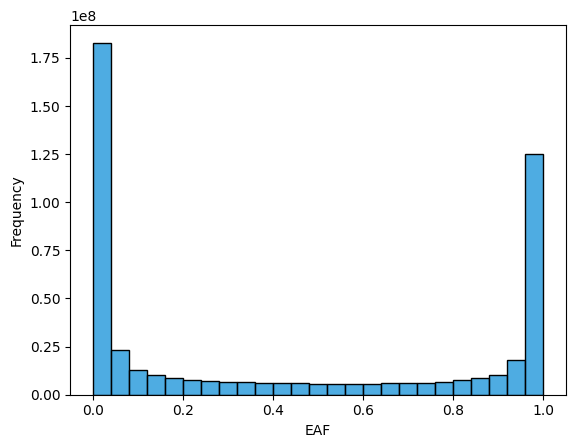

In [74]:
import seaborn as sns

sns.histplot(
    data=cad1m_data,  # gwas_combo_sample,
    x="EAF",
    bins=25,
    kde=False,
    stat="frequency",
    color="#1290D9",
)

# plt.savefig(
#     os.path.join(PLOTS_loc, "histogram.EAF.WOMEN." + POPULATION + ".png"),
#     dpi=300,
#     bbox_inches="tight",
#     format="png",
# )
plt.savefig(
    os.path.join(PLOTS_loc, "histogram.EAF." + PHENOTYPE + "_" + SEX + "_" + POPULATION + ".pdf"),
    dpi=300,
    bbox_inches="tight",
    format="pdf",
)

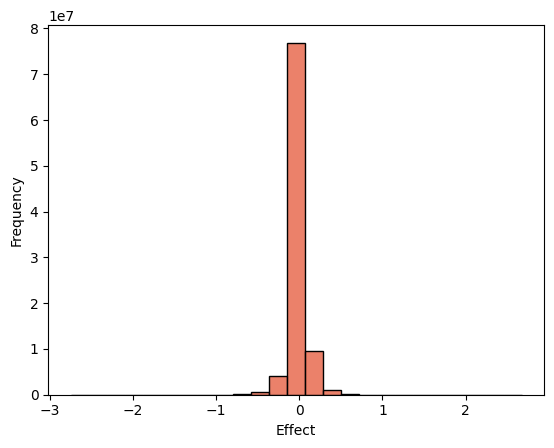

In [75]:
sns.histplot(
    data=cad1m_data,  # gwas_combo_sample,
    x="Effect",
    bins=25,
    kde=False,
    stat="frequency",
    color="#E55738",
)

# plt.savefig(
#     os.path.join(PLOTS_loc, "histogram.effect.WOMEN." + POPULATION + ".png"),
#     dpi=300,
#     bbox_inches="tight",
#     format="png",
# )
plt.savefig(
    os.path.join(PLOTS_loc, "histogram.effect." + PHENOTYPE + "_" + SEX + "_" + POPULATION + ".pdf"),
    dpi=300,
    bbox_inches="tight",
    format="pdf",
)

### SumStats quality control

Here we first check and fix headers, and contents of the SumStats object.

First, we load the data and inspect it using `GWASLab`. Note that for this to work, some column types need to be adjusted.

```
 0   SNP                object
 1   CHR                object
 2   POS                int64
 3   HAPMAP_A1_FREQ     float64
 4   CODED_ALLELE       object
 5   NONCODED_ALLELE    object
 6   CODED_ALLELE_FREQ  float64
 7   N_EFF              float64
 8   P_SQRTN            float64
 9   BETA_FIXED         float64
 10  SE_FIXED           float64
 11  P_FIXED            float64
 12  P_RANDOM           float64
 13  DF                 int64
 14  P_COCHRANS_Q       float64
 15  I_SQUARED          float64
 16  DIRECTIONS         object
 17  GENES_1000KB       object
 18  NEAREST_GENE       object
 19  CAVEAT             object
```


In [ ]:
# cimt_data[["CHR"]] = cimt_data[["CHR"]].astype("object")

In [ ]:
# cimt_data[["POS"]] = cimt_data[["POS"]].astype("Int64")

In [ ]:
# # create new SNPID column based on chromosome, position, and alleles
# # down the road we need an SNPID column to merge with the reference data and which does not contain 'ID' because this is not correctly interpreted by GWASLab
# cimt_data["SNPID"] = (
#     cimt_data["CHR"].astype(str)
#     + ":"
#     + cimt_data["POS"].astype(str)
#     + ":"
#     + cimt_data["OTHERALLELE"].astype(str)
#     + ":"
#     + cimt_data["CODEDALLELE"].astype(str)
# )

# # from an *.out file at /hpc/dhl_ec/svanderlaan/projects/sign/vonberg_joanna/2.Age.of.onset/linreg_aoo_unrestricted_bolt/amr.everything.butwhi/xx.group
# # cimt_data["N"] = 5344

In [ ]:
# cimt_data.head()

In [ ]:
# cimt_data.rename(columns={"SNP": "VariantID"}, inplace=True)

### Converting to GWASLab object

Here we are ready to load the data and inspect it using `GWASLab`.


In [76]:
# cimt_data_sumstats.data

In [77]:
import gwaslab as gl

# Specify the columns:
cimt_data_sumstats_female = gl.Sumstats(
    cimt_data_female,
    snpid="VARIANTID",
    # rsid="RSID", # not available
    chrom="CHR",
    pos="POS",
    ea="CODEDALLELE",
    nea="OTHERALLELE",
    eaf="CAF",
    beta="BETA_FIXED",
    se="SE_FIXED",
    p="P_FIXED",
    # direction="Direction",  # only for meta-GWAS
    n="N_EFF",
    # info="Info", # not available
    other=[
        "DF",
        "DIRECTIONS",
        "P_COCHRANS_Q",
        "I_SQUARED",
        "CAVEAT",
    ],
    build="19",
    verbose=True,
)

ImportError: dlopen(/Users/slaan3/miniforge3/envs/gwaslab/lib/python3.9/site-packages/liftover/chain_file.cpython-39-darwin.so, 0x0002): Library not loaded: /usr/local/opt/llvm/lib/libunwind.1.dylib
  Referenced from: <C7189951-C303-3D12-9E0C-787B1049DFF1> /Users/slaan3/miniforge3/envs/gwaslab/lib/python3.9/site-packages/liftover/chain_file.cpython-39-darwin.so
  Reason: tried: '/usr/local/opt/llvm/lib/libunwind.1.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/llvm/lib/libunwind.1.dylib' (no such file), '/usr/local/opt/llvm/lib/libunwind.1.dylib' (no such file), '/usr/local/lib/libunwind.1.dylib' (no such file), '/usr/lib/libunwind.1.dylib' (no such file, not in dyld cache), '/usr/local/Cellar/llvm/19.1.2/lib/libunwind.1.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/Cellar/llvm/19.1.2/lib/libunwind.1.dylib' (no such file), '/usr/local/Cellar/llvm/19.1.2/lib/libunwind.1.dylib' (no such file), '/usr/local/lib/libunwind.1.dylib' (no such file), '/usr/lib/libunwind.1.dylib' (no such file, not in dyld cache)

In [ ]:
# cimt_data_sumstats.summary()

In [ ]:
# cimt_data_sumstats.lookup_status()

#### Intermediate cleaning

Here we cleanup the originally loaded data, to clear memory.


In [ ]:
# del cimt_data

In [16]:
del cimt_data_female

In [77]:
del cimt_data_male

#### Get reference data

We align the data to the reference genome, this will work for most common variants. Before that, we check which reference datasets are available, and get these.


In [ ]:
# check references
gl.check_available_ref()

# {'1kg_eas_hg19': 'https://www.dropbox.com/s/lztaxqhy2o6dpxw/EAS.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?dl=1',
#  '1kg_eas_hg19_md5': 'c8c97434843c0da3113fc06879ead472',
#  '1kg_eas_hg19_tbi': 'https://www.dropbox.com/s/k9klefl8m9fcfo1/EAS.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?dl=1',
#  '1kg_eur_hg19': 'https://www.dropbox.com/s/1nbgqshknevseks/amr.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?dl=1',
#  '1kg_eur_hg19_md5': '734069d895009d38c2f962bfbb6fab52',
#  '1kg_eur_hg19_tbi': 'https://www.dropbox.com/s/vscvkrflh6fc5a0/amr.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?dl=1',
#  '1kg_eas_hg38': 'https://www.dropbox.com/s/3dstbbb1el9r3au/EAS.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?dl=1',
#  '1kg_eas_hg38_md5': 'f45e80bca9ef7b29e6b1832e6ac15375',
#  '1kg_eas_hg38_tbi': 'https://www.dropbox.com/s/vwnp5vd8dcqksn4/EAS.ALL.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?dl=1',
#  '1kg_eur_hg38': 'https://www.dropbox.com/s/z0mkehg17lryapv/amr.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?dl=1',
#  '1kg_eur_hg38_md5': '228d3285fa99132cc6321e2925e0768d',
#  '1kg_eur_hg38_tbi': 'https://www.dropbox.com/s/ze8g58x75x9qbf0/amr.ALL.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?dl=1',
#  '1kg_sas_hg19': 'https://www.dropbox.com/scl/fi/fubqvuj3p4ii4y35zknv8/SAS.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?rlkey=5z50f66iltjchcaszznq5bczt&dl=1',
#  '1kg_sas_hg19_md5': 'e2d3f9e2e6580d05e877e9effd435c4e',
#  '1kg_sas_hg19_tbi': 'https://www.dropbox.com/scl/fi/icnmrnzee7ofdpx5l96tg/SAS.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?rlkey=st8t88snby26q37rqi6zh5zck&dl=1',
#  '1kg_amr_hg19': 'https://www.dropbox.com/scl/fi/bxa4zfngsxsc38rhtiv8c/AMR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?rlkey=ibcn8hb1n8n36j3u0jfzci267&dl=1',
#  '1kg_amr_hg19_md5': '68d3cdf01cbabdae6e74a07795fa881c',
#  '1kg_amr_hg19_tbi': 'https://www.dropbox.com/scl/fi/1zk16x7h4r89jurzwu05u/AMR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?rlkey=b4cere4w38zvzyfitfge3r8n0&dl=1',
#  '1kg_sas_hg38': 'https://www.dropbox.com/scl/fi/jr3l5zz42py3kny2bccmj/SAS.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?rlkey=x0t6tsy71jxzf021wfqdn8k5q&dl=1',
#  '1kg_sas_hg38_md5': 'e5d79bea1958aa50c23f618d342ccc83',
#  '1kg_sas_hg38_tbi': 'https://www.dropbox.com/scl/fi/02oia4ur5r7w9qgiuf6i9/SAS.ALL.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?rlkey=00p9rxe0xzfs6hr1rg4d8oadm&dl=1',
#  '1kg_amr_hg38': 'https://www.dropbox.com/scl/fi/4t4tyuhzp78uyb6tgkroq/AMR.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?rlkey=p96gbs1tcdia31jnjv1b82kuz&dl=1',
#  '1kg_amr_hg38_md5': '229fbd610001cf6f137b7f738352a44a',
#  '1kg_amr_hg38_tbi': 'https://www.dropbox.com/scl/fi/x0dby543tr9xpaqj2i0ba/AMR.ALL.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?rlkey=uj8o7j0cy0spipe174jn54sqs&dl=1',
#  '1kg_afr_hg19': https://www.dropbox.com/scl/fi/tq4w9lyt5z47ym7grtrxg/AFR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?rlkey=k3bimeu3yr5loq8hohba5mr6k&dl=1,
#  '1kg_afr_hg19_md5': 'f7b4425f39e8292dce6f13711e7f6c50',
#  '1kg_afr_hg19_tbi': 'https://www.dropbox.com/scl/fi/0giiptu0btwj1kfm6jdzr/AFR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?rlkey=ucb5weprsc5prcg8hvtgmruxx&dl=1',
#  '1kg_pan_hg19': 'https://www.dropbox.com/scl/fi/6b4j9z9knmllfnbx86aw6/PAN.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?rlkey=eento8vg06zyrkvooc9wd4cvu&dl=1',
#  '1kg_pan_hg19_md5': 'fed846482204487b60d33b21ddb18106',
#  '1kg_pan_hg19_tbi': 'https://www.dropbox.com/scl/fi/stco946scio5tvto0ln4j/PAN.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?rlkey=hfh53beb627lmqwv3d8mzqy0c&dl=1',
#  '1kg_afr_hg38': 'https://www.dropbox.com/scl/fi/239xmm7qijtnsks97chc9/AFR.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?rlkey=47en5fk1icbekpg7we3uot9g8&dl=1',
#  '1kg_afr_hg38_md5': '3bb7923be0809a324d7b7633b8d58a3b',
#  '1kg_afr_hg38_tbi': 'https://www.dropbox.com/scl/fi/3y3pg4yqwo2jaaamx1c8f/AFR.ALL.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?rlkey=say0ihfwa51z3otgn4bjtze8p&dl=1',
#  '1kg_pan_hg38': 'https://www.dropbox.com/scl/fi/nf01487smtmeq243ihfwm/PAN.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?rlkey=3pefbkzxwcnejx4inynifpft7&dl=1',
#  '1kg_pan_hg38_md5': '23bb86d748c4a66e85e087f647e8b60e',
#  '1kg_pan_hg38_tbi': 'https://www.dropbox.com/scl/fi/hu7cttr4cenw5yjsm2775/PAN.ALL.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?rlkey=568u7bkvkybm4wt2q9284o198&dl=1',
#  'dbsnp_v151_hg19': 'https://ftp.ncbi.nih.gov/snp/organisms/human_9606_b151_GRCh37p13/VCF/00-All.vcf.gz',
#  'dbsnp_v151_hg19_tbi': 'https://ftp.ncbi.nih.gov/snp/organisms/human_9606_b151_GRCh37p13/VCF/00-All.vcf.gz.tbi',
#  'dbsnp_v151_hg38': 'https://ftp.ncbi.nih.gov/snp/organisms/human_9606_b151_GRCh38p7/VCF/00-All.vcf.gz',
#  'dbsnp_v151_hg38_tbi': 'https://ftp.ncbi.nih.gov/snp/organisms/human_9606_b151_GRCh38p7/VCF/00-All.vcf.gz.tbi',
#  'dbsnp_v156_hg19': 'https://ftp.ncbi.nih.gov/snp/archive/b156/VCF/GCF_000001405.25.gz',
#  'dbsnp_v156_hg19_tbi': 'https://ftp.ncbi.nih.gov/snp/archive/b156/VCF/GCF_000001405.25.gz.tbi',
#  'dbsnp_v156_hg38': 'https://ftp.ncbi.nih.gov/snp/archive/b156/VCF/GCF_000001405.40.gz',
#  'dbsnp_v156_hg38_tbi': 'https://ftp.ncbi.nih.gov/snp/archive/b156/VCF/GCF_000001405.40.gz.tbi',
#  'ucsc_genome_hg19': 'http://hgdownload.cse.ucsc.edu/goldenpath/hg19/bigZips/hg19.fa.gz',
#  'ucsc_genome_hg38': 'https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz',
#  '1kg_dbsnp151_hg19_auto': 'https://www.dropbox.com/s/37p2u1xwmux4gwo/1kg_dbsnp151_hg19_auto.txt.gz?dl=1',
#  '1kg_dbsnp151_hg19_auto_md5': '7d1e7624fb6e4df7a2f6f05558d436b4',
#  '1kg_dbsnp151_hg38_auto': 'https://www.dropbox.com/s/ouf60n7gdz6cm0g/1kg_dbsnp151_hg38_auto.txt.gz?dl=1',
#  '1kg_dbsnp151_hg38_auto_md5': '4c7ef2d2415c18c286219e970fdda972',
#  'recombination_hg19': 'https://www.dropbox.com/s/wbesl8haxknonuc/recombination_hg19.tar.gz?dl=1',
#  'recombination_hg38': 'https://www.dropbox.com/s/vuo8mvqx0fpibzj/recombination_hg38.tar.gz?dl=1',
#  'ensembl_hg19_gtf': 'https://ftp.ensembl.org/pub/grch37/current/gtf/homo_sapiens/Homo_sapiens.GRCh37.87.chr.gtf.gz',
#  'ensembl_hg38_gtf': 'https://ftp.ensembl.org/pub/release-109/gtf/homo_sapiens//Homo_sapiens.GRCh38.109.chr.gtf.gz',
#  'refseq_hg19_gtf': 'https://ftp.ncbi.nlm.nih.gov/refseq/H_sapiens/annotation/GRCh37_latest/refseq_identifiers/GRCh37_latest_genomic.gtf.gz',
#  'refseq_hg38_gtf': 'https://ftp.ncbi.nlm.nih.gov/refseq/H_sapiens/annotation/GRCh38_latest/refseq_identifiers/GRCh38_latest_genomic.gtf.gz',
#  'testlink': 'https://www.dropbox.com/s/8u7capwge0ihshu/EAS.chr22.split_norm_af.1kgp3v5.vcf.gz?dl=1',
#  'testlink_tbi': 'https://www.dropbox.com/s/hdneg53t6u1j6ib/EAS.chr22.split_norm_af.1kgp3v5.vcf.gz.tbi?dl=1'}

In [ ]:
# download ref SNPID-rsID table first
# hg19 is the same as GRCh37, which is the same as b37, which is the same as 19
# USCSC Genome Browser hg19, SNP information
gl.download_ref("ucsc_genome_hg19")
# combined 1KG and dbSNP151, hg19, autosomes
gl.download_ref("1kg_dbsnp151_hg19_auto")
# gl.download_ref("refseq_hg19_gtf") # gene annotation, hg19

In [ ]:
gl.download_ref("dbsnp_v156_hg19")

In [ ]:
gl.download_ref("dbsnp_v156_hg19_tbi")

In [ ]:
# download_ref
gl.download_ref(REF_1KG)

In [ ]:
# download_ref("recombination_hg19") - get recombination map for hg19
gl.download_ref("recombination_hg19")

In [ ]:
# download_ref("ensembl_hg19_gtf") - get the Ensembl GTF file for hg19
gl.download_ref("ensembl_hg19_gtf")

In [ ]:
# download_ref("refseq_hg19_gtf") - get the refseq hg19 gtf file
gl.download_ref("refseq_hg19_gtf")

### Basic check, harmonization, normalization, quality control, and filtering

Here we fix the dataset.


#### Basic check

Here we apply basic check to the data, which makes sure that:

- SNPIDs are of the form chr:bp
- orders the data
- all alleles are capitalized
- does sanity checks on data

However, no data is filtered, and normalization (to a reference) is also not applied!


In [ ]:
# Execute `bacis_check` function - first we just make sure the data has the expected format, columns, and datatypes.
# full data
# cimt_data_sumstats.basic_check(verbose=True)

In [ ]:
cimt_data_sumstats_female.basic_check(verbose=True)

In [ ]:
cimt_data_sumstats_male.basic_check(verbose=True)

In [ ]:
# check the form of the data as it is AFTER `basic_check` function
# full data
# cimt_data_sumstats.data

In [ ]:
# cimt_data_sumstats.summary()

In [ ]:
# cimt_data_sumstats.lookup_status()

#### Remove duplicate and multi-allelic variants

Here we remove duplicate and multi-allelic variants, and keep the variants with the lowest P-value for association.


In [ ]:
# removing multiallelic and duplicate variants
# mode=d ,remove duplicate.
#     remove duplicate SNPs based on 1. SNPID,
#     remove duplicate SNPs based on 2. CHR, POS, EA, and NEA
#     remove duplicate SNPs based on 3. rsID
# mode=m, remove multiallelic variants.
#     remove multiallelic SNPs based on 4. CHR, POS
# remove=True : remove NAs
# keep_col : use which column to sort the values (keep_ascend=True: ascending order)
# keep: keep 'first' or 'last'.

# gwas_combo_sumstats_sample.remove_dup(
#     mode="md",  # remove multi-allelic and duplicate variants
#     remove=True,  # remove NAs
#     keep_col="P",
#     keep_ascend=True,
#     keep="first",  # keep the first variant, with the lowest p-value (sorted by that column)
# )

In [ ]:
# # full dataset
# cimt_data_sumstats.remove_dup(
#     mode="md",  # remove multi-allelic and duplicate variants
#     remove=False,  # remove NAs
#     keep_col="P",
#     keep_ascend=True,
#     # keep the first variant, with the lowest p-value (sorted by that column)
#     keep="first",
# )

In [ ]:
# full dataset
cimt_data_sumstats_female.remove_dup(
    mode="md",  # remove multi-allelic and duplicate variants
    remove=False,  # remove NAs
    keep_col="P",
    keep_ascend=True,
    # keep the first variant, with the lowest p-value (sorted by that column)
    keep="first",
)

In [ ]:
# full dataset
cimt_data_sumstats_male.remove_dup(
    mode="md",  # remove multi-allelic and duplicate variants
    remove=False,  # remove NAs
    keep_col="P",
    keep_ascend=True,
    # keep the first variant, with the lowest p-value (sorted by that column)
    keep="first",
)

#### Harmonization

Here we harmonize the data with the reference:

- we make sure alleles are oriented according to the reference
- we assign rsIDs
- we flip alleles (and effect sizes), when necessary


##### Align NEA with REF in the reference genome

We check if the non-effect allele is aligned with the reference sequence (`hg19`). The status code will be changed accordingly.


In [ ]:
# # .check_ref(): Check if NEA is aligned with the reference sequence. After checking, the tracking status code will be changed accordingly.

# # full dataset
# cimt_data_sumstats.check_ref(
#     ref_path=gl.get_path("ucsc_genome_hg19"),
#     #   chr_dict=gl.get_number_to_NC(build="19")
# )

In [ ]:
# .check_ref(): Check if NEA is aligned with the reference sequence. After checking, the tracking status code will be changed accordingly.

# full dataset
cimt_data_sumstats_female.check_ref(
    ref_seq=gl.get_path("ucsc_genome_hg19"),
    #   chr_dict=gl.get_number_to_NC(build="19")
)

In [ ]:
# .check_ref(): Check if NEA is aligned with the reference sequence. After checking, the tracking status code will be changed accordingly.

# full dataset
cimt_data_sumstats_male.check_ref(
    ref_seq=gl.get_path("ucsc_genome_hg19"),
    #   chr_dict=gl.get_number_to_NC(build="19")
)

In [ ]:
# we make sure to flipp the alleles based on the status code

# full dataset
# cimt_data_sumstats.flip_allele_stats()

In [ ]:
# we make sure to flipp the alleles based on the status code

# full dataset
cimt_data_sumstats_female.flip_allele_stats()

In [ ]:
# we make sure to flipp the alleles based on the status code

# full dataset
cimt_data_sumstats_male.flip_allele_stats()

In [ ]:
# cimt_data_sumstats.lookup_status()

##### Check palindromic SNPs or indistinguishable Indels

Here we check for palindromic variants and indistinguishable INDELs and remove these.


In [ ]:
# .infer_strand() - skipped as this is done
# ref_infer= gl.get_path("1kg_AFR_hg19"), # reference vcf file
# ref_alt_freq=None,
# maf_threshold=0.40, # maf threshold for strand inference
# remove_snp="", # remove snps from the data
# mode="pi",
# n_cores=1,
# remove_indel=""

# first we check the strand of the data and assign the status code
# gwas_combo_sumstats_sample.infer_strand(ref_infer=gl.get_path("1kg_AFR_hg19"), n_cores=6)

# full data
# gwas_combo_sumstats.infer_strand(ref_infer = gl.get_path("1kg_AFR_hg19"),
#                                        n_cores=6)
# then we flip the alleles according to the status code
# gwas_combo_sumstats_sample.flip_allele_stats()

In [ ]:
# cimt_data_sumstats.infer_strand(ref_infer=gl.get_path(REF_1KG), n_cores=8)

In [ ]:
cimt_data_sumstats_female.infer_strand(ref_infer="/Users/esmulde2/.gwaslab/AFR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz", n_cores=8)


In [ ]:
cimt_data_sumstats_male.infer_strand(ref_infer="/Users/esmulde2/.gwaslab/AFR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz", n_cores=8)


In [ ]:
# cimt_data_sumstats.flip_allele_stats()

In [ ]:
# we make sure to flipp the alleles based on the status code

# full dataset
cimt_data_sumstats_female.flip_allele_stats()

In [ ]:
# we make sure to flipp the alleles based on the status code

# full dataset
cimt_data_sumstats_male.flip_allele_stats()

##### Assign rsID to the data

For the sample dataset this will take not much time. For a dataset with 8M variants it will take about 50-60 minutes! We should fix the SNPIDs such that it includes the alleles. This way the assigning of rsID will go smoothly.


In [ ]:
cimt_data_sumstats_sample = cimt_data_sumstats_female.random_variants(n=200000)

In [ ]:
# rsID annotation based on chr, pos, ref, alt using a VCF file when the SNPID is of the form chr:pos.
# .assign_rsid() options	DataType	Description	Default
# ref_rsid_tsv	string	tsv file path for annotation of commonly used variants using SNPID (like 1:725932:G:A) as key.	-
# ref_rsid_vcf	string	vcf file path for annotation of other variants. .tbi file is also needed.	-
# chr_dict	dict	a dictionary for converting 1-25 to CHR in the vcf files.
# For example, the notation in dbSNP vcf file is based on RefSeq (like NC_000001.10).
# gwaslab provides built-in conversion dictionaries.
# gl.get_number_to_NC(build="19")
# n_cores	int	number of cores to use.

# cimt_data_sumstats_sample.assign_rsid(
#     n_cores=4,
#     # ref_rsid_tsv = gl.get_path("1kg_dbsnp151_hg19_auto"),
#     ref_rsid_vcf="/Volumes/MacExtern/UMC/Werk/GCF_000001405.25.gz",  # this works when SNPID is in the format chr:pos
#     chr_dict=gl.get_number_to_NC(
#         build="19"
#     ),  # this is needed as in the VCF file, the chromosome is in NC format
# )

In [ ]:
cimt_data_sumstats_female.assign_rsid(
    n_cores=4,
    # ref_rsid_tsv = gl.get_path("1kg_dbsnp151_hg19_auto"),
    ref_rsid_vcf="/Volumes/MacExtern/UMC/Werk/GCF_000001405.25.gz",  # this works when SNPID is in the format chr:pos
    chr_dict=gl.get_number_to_NC(
        build="19"
    ),  # this is needed as in the VCF file, the chromosome is in NC format
)

In [ ]:
cimt_data_sumstats_male.assign_rsid(
    n_cores=4,
    # ref_rsid_tsv = gl.get_path("1kg_dbsnp151_hg19_auto"),
    ref_rsid_vcf="/Volumes/MacExtern/UMC/Werk/GCF_000001405.25.gz",  # this works when SNPID is in the format chr:pos
    chr_dict=gl.get_number_to_NC(
        build="19"
    ),  # this is needed as in the VCF file, the chromosome is in NC format
)

In [ ]:
# cimt_data_sumstats.fix_id(
#     fixid=True,
#     forcefixid=True,
# )

In [ ]:
cimt_data_sumstats_female.fix_id(
    fixid=True,
    forcefixid=True,
    overwrite=True,
)

In [ ]:
cimt_data_sumstats_male.fix_id(
    fixid=True,
    forcefixid=True,
    overwrite=True,
)

In [ ]:
cimt_data_sumstats_female.data

In [ ]:
cimt_data_sumstats_sample.data

In [ ]:
cimt_data_sumstats_sample.fix_id(
    fixid=True,
    forcefixid=True,
    overwrite=True,
)

In [ ]:
# cimt_data_sumstats.assign_rsid(
#     n_cores=8,
#     # this works for common variants
#     ref_rsid_tsv=gl.get_path("1kg_dbsnp151_hg19_auto"),
#     # ref_rsid_vcf=gl.get_path("dbsnp_v156_hg19"),
#     chr_dict=gl.get_number_to_NC(
#         build="19"
#     ),  # this is needed as in the VCF file, the chromosome is in NC format
# )

In [ ]:
# cimt_data_sumstats_female.assign_rsid(
#     n_cores=8,
#     # this works for common variants
#     ref_rsid_tsv=gl.get_path("1kg_dbsnp151_hg19_auto"),
#     # ref_rsid_vcf=gl.get_path("dbsnp_v156_hg19"),
#     chr_dict=gl.get_number_to_NC(
#         build="19"
#     ),  # this is needed as in the VCF file, the chromosome is in NC format
# )

In [ ]:
# cimt_data_sumstats_male.assign_rsid(
#     n_cores=8,
#     # this works for common variants
#     ref_rsid_tsv=gl.get_path("1kg_dbsnp151_hg19_auto"),
#     # ref_rsid_vcf=gl.get_path("dbsnp_v156_hg19"),
#     chr_dict=gl.get_number_to_NC(
#         build="19"
#     ),  # this is needed as in the VCF file, the chromosome is in NC format
# )

In [ ]:
cimt_data_sumstats_female.summary()

In [ ]:
cimt_data_sumstats_female.lookup_status()

##### Plot frequencies of data against the reference

We would like to plot the frequency of the GWAS data compared to the reference data. We do this on a random subset of the data (n=200,000) as this is more efficient and should be representative of the full datasets.


In [ ]:
# cimt_data_sumstats_sample = cimt_data_sumstats.random_variants(n=200000)

In [ ]:
# cimt_data_sumstats_sample.check_af(
#      ref_infer=gl.get_path(REF_1KG),
#     ref_alt_freq="AF",
#     n_cores=8,
# )

In [ ]:
# cimt_data_sumstats.check_af(
#     ref_infer=gl.get_path(REF_1KG),
#     ref_alt_freq="AF",
#     n_cores=8,
# )

In [ ]:
cimt_data_sumstats_female.check_af(
    ref_infer="/Users/esmulde2/.gwaslab/AFR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz",
    ref_alt_freq="AF",
    n_cores=8,
)

In [ ]:
cimt_data_sumstats_male.check_af(
    ref_infer="/Users/esmulde2/.gwaslab/AFR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz",
    ref_alt_freq="AF",
    n_cores=8,
)

In [ ]:
# cimt_data_sumstats_sample.plot_daf(threshold=0.12)

In [ ]:
# cimt_data_sumstats.plot_daf(threshold=0.12)

In [ ]:
cimt_data_sumstats_female.plot_daf(threshold=0.12)

In [ ]:
cimt_data_sumstats_male.plot_daf(threshold=0.12)

In [ ]:
# del cimt_data_sumstats_sample

##### Summary

So in summary we have done:

- a basic check, making sure the chr, pos, alleles are all in order
- multi-allelic, weird chromosomes, and duplicate variants are removed
- data are harmonized, such that the rsID is added, the alleles are relative to the references (and flipped if needed)

> Note, while we do calculate the difference in allele frequencies between the datasets and the reference, we **do not** filter on this for the purpose of sharing through _GWAS Catalog_.


In [ ]:
# print("The parsed and harmonized SumStats object:\n")

# cimt_data_sumstats.data

In [ ]:
# cimt_data_sumstats.data["CAVEAT"].unique()

In [ ]:
cimt_data_sumstats_female.data["CAVEAT"].unique()

In [ ]:
cimt_data_sumstats_male.data["CAVEAT"].unique()

In [ ]:
# temp.to_csv(
#     os.path.join(
#         GWASCatalog_loc + "/META_" + PHENOTYPE + "_" + SEX + "_" + POPULATION + ".counts_caveats.csv",
#     )
# )

In [33]:
temp = cimt_data_sumstats_female.data["CAVEAT"].value_counts()

temp.to_csv(
    os.path.join(
        GWASCatalog_loc + "/META_" + PHENOTYPE + "_" + SEX1 + "_" + POPULATION + ".counts_caveats.csv",
    )
)

In [47]:
temp = cimt_data_sumstats_male.data["CAVEAT"].value_counts()

temp.to_csv(
    os.path.join(
        GWASCatalog_loc + "/META_" + PHENOTYPE + "_" + SEX2 + "_" + POPULATION + ".counts_caveats.csv",
    )
)

### Save or open data

Let's save (or open) the summary statistics object for future reference.


In [ ]:
# import gwaslab as gl

# gl.dump_pickle(
#     cimt_data_sumstats,
#     os.path.join(
#         GWASCatalog_loc + "/META_" + PHENOTYPE + "_" + SEX + "_" + POPULATION + ".gwaslab.pkl",
#     ),
#     overwrite=True,
# )

In [ ]:
import gwaslab as gl

gl.dump_pickle(
    cimt_data_sumstats_female,
    os.path.join(
        GWASCatalog_loc + "/META_" + PHENOTYPE + "_" + SEX1 + "_" + POPULATION + ".b37.gwaslab.pkl",
    ),
    overwrite=True,
)

In [ ]:
import gwaslab as gl

gl.dump_pickle(
    cimt_data_sumstats_male,
    os.path.join(
        GWASCatalog_loc + "/META_" + PHENOTYPE + "_" + SEX2 + "_" + POPULATION + ".b37.gwaslab.pkl",
    ),
    overwrite=True,
)

In [ ]:
# for future reference to open the pickle file
# cimt_data_sumstats = gl.load_pickle(
#     os.path.join(
#         GWASCatalog_loc + "/META_" + PHENOTYPE + "_" + POPULATION + "_" + SEX + ".gwaslab.pkl")
# )

In [ ]:
# import gwaslab as gl

# cimt_data_sumstats.log.show()

# cimt_data_sumstats.log.save(
#     os.path.join(
#         GWASCatalog_loc + "/META_" + PHENOTYPE + "_" + SEX + "_" + POPULATION + ".b37.gwaslab.log",
#     )
# )

In [ ]:
import gwaslab as gl

cimt_data_sumstats_female.log.show()

cimt_data_sumstats_female.log.save(
    os.path.join(
        GWASCatalog_loc + "/META_" + PHENOTYPE + "_" + SEX1 + "_" + POPULATION + ".b37.gwaslab.log",
    )
)

In [ ]:
import gwaslab as gl

cimt_data_sumstats_male.log.show()

cimt_data_sumstats_male.log.save(
    os.path.join(
        GWASCatalog_loc + "/META_" + PHENOTYPE + "_" + SEX2 + "_" + POPULATION + ".b37.gwaslab.log",
    )
)

LOAD PICKLE FILES


In [ ]:
cimt_data_sumstats_female = gl.load_pickle(
    os.path.join(
        GWASCatalog_loc + "/META_" + PHENOTYPE + "_" + SEX1 + "_" + POPULATION + ".b37.gwaslab.pkl",
    )
)

In [ ]:
cimt_data_sumstats_male = gl.load_pickle(
    os.path.join(
        GWASCatalog_loc + "/META_" + PHENOTYPE + "_" + SEX2 + "_" + POPULATION + ".b37.gwaslab.pkl",
    )
)

In [ ]:
cimt_data_sumstats_qc_female = gl.load_pickle(
    os.path.join(
        GWASCatalog_loc + "/META_" + PHENOTYPE + "_" + SEX1 + "_" + POPULATION + ".b37.gwaslab.qc.pkl",
    )
)

In [ ]:
cimt_data_sumstats_qc_male = gl.load_pickle(
    os.path.join(
        GWASCatalog_loc + "/META_" + PHENOTYPE + "_" + SEX2 + "_" + POPULATION + ".b37.gwaslab.qc.pkl",
    )
)

##### Parquet

Save it as a parquet for easy loading as a dataframe in other programs (_e.g._ `R`).


In [ ]:
import pyarrow as pa
import pyarrow.parquet as pq

# Convert DataFrame to Apache Arrow Table
temp_table = pa.Table.from_pandas(cimt_data_sumstats.data)

# Parquet with Brotli compression
pq.write_table(
    temp_table,
    os.path.join(
        GWASCatalog_loc + "/META_" + PHENOTYPE + "_" + SEX + "_" + POPULATION + ".b37.gwaslab.parquet",
    ),
    compression="BROTLI",
)
# we delete the temporary table object
del temp_table

##### GWAS Catalog

Save it in `GWAS catalog`-format


In [ ]:
# cimt_datasumstats.to_format(
#     os.path.join(GWASCatalog_loc + "/META_" + PHENOTYPE + "_" + SEX + "_" + POPULATION + ".b37.gwaslab"),
#     fmt="ssf",
#     build="19",
# )

In [ ]:
cimt_data_sumstats_female.to_format(
    os.path.join(GWASCatalog_loc + "/META_" + PHENOTYPE + "_" + SEX1 + "_" + POPULATION + ".b37.gwaslab"),
    fmt="ssf",
    build="19",
)

In [ ]:
cimt_data_sumstats_male.to_format(
    os.path.join(GWASCatalog_loc + "/META_" + PHENOTYPE + "_" + SEX2 + "_" + POPULATION + ".b37.gwaslab"),
    fmt="ssf",
    build="19",
)

After this, we need to validate results for `GWAS Catalog`. For this purpose we created an environment based on python 3.9 and used `gwas-sumstats-tools` (https://github.com/EBISPOT/gwas-sumstats-tools). We remove any remaining variant with alleles formatted such that is unacceptable for `GWAS Catalog`.


### FUMA


In [ ]:
cimt_data_sumstats_female.to_format(
    os.path.join(GWASCatalog_loc + "/META_" + PHENOTYPE + "_" + SEX1 + "_" + POPULATION + ".b37.gwaslab"),
    fmt="fuma",
    build="19",
)

In [ ]:
cimt_data_sumstats_male.to_format(
    os.path.join(GWASCatalog_loc + "/META_" + PHENOTYPE + "_" + SEX2 + "_" + POPULATION + ".b37.gwaslab"),
    fmt="fuma",
    build="19",
)

### Filtering


Let's filter based on the following:

- CAVEAT == None


In [ ]:
# cimt_data_sumstats.data.dtypes

In [ ]:
# cimt_data_sumstats_qc = cimt_data_sumstats.filter_value(
#     '(EAF>=0.01 & EAF<0.99 & DF>=1) | CAVEAT==None'
# )

# #cimt_data_sumstats_qc = cimt_data_sumstats.filter_value('CAVEAT== None')

In [ ]:
cimt_data_sumstats_qc_female = cimt_data_sumstats_female.filter_value(
    '(EAF>=0.01 & EAF<0.99 & DF>=1) | CAVEAT==None'
)

#cimt_data_sumstats_qc = cimt_data_sumstats.filter_value('CAVEAT== None')

In [ ]:
cimt_data_sumstats_qc_male = cimt_data_sumstats_male.filter_value(
    '(EAF>=0.01 & EAF<0.99 & DF>=1) | CAVEAT==None'
)

#cimt_data_sumstats_qc = cimt_data_sumstats.filter_value('CAVEAT== None')

In [ ]:
# cimt_data_sumstats_qc_male.data

In [ ]:
# cimt_data_sumstats_qc_male.summary()

In [ ]:
# cimt_data_sumstats_qc_male.lookup_status()

In [ ]:
# import gwaslab as gl

# gl.dump_pickle(
#     cimt_data_sumstats_qc,
#     os.path.join(
#         GWASCatalog_loc + "/META_" + PHENOTYPE + "_" + SEX + "_" + POPULATION + ".b37.gwaslab.qc.pkl",
#     ),
#     overwrite=True,
# )

# # # cimt_data_sumstats_qc = gl.load_pickle(
# # #     os.path.join(
# # #         GWAS_RES_loc,
# # #         "meta_analysis/" + SUBSTUDY_WOMEN + "/AIS_WOMEN_" + POPULATION + "_b37_qc.gwaslab.pkl",
# # #     )
# # # )

# cimt_data_sumstats_qc.log.show()

# cimt_data_sumstats_qc.log.save(
#     os.path.join(
#         GWASCatalog_loc + "/META_" + PHENOTYPE + "_" + SEX + "_" + POPULATION + ".b37.gwaslab.qc.log",
#     )
# )

In [ ]:
import gwaslab as gl

gl.dump_pickle(
    cimt_data_sumstats_qc_female,
    os.path.join(
        GWASCatalog_loc + "/META_" + PHENOTYPE + "_" + SEX1 + "_" + POPULATION + ".b37.gwaslab.qc.pkl",
    ),
    overwrite=True,
)

In [ ]:
cimt_data_sumstats_qc_female.to_format(
    os.path.join(GWASCatalog_loc + "/META_" + PHENOTYPE + "_" + SEX1 + "_" + POPULATION + ".b37.qc.gwaslab"),
    fmt="ssf",
    build="19",
)

In [ ]:
import gwaslab as gl

gl.dump_pickle(
    cimt_data_sumstats_qc_male,
    os.path.join(
        GWASCatalog_loc + "/META_" + PHENOTYPE + "_" + SEX2 + "_" + POPULATION + ".b37.gwaslab.qc.pkl",
    ),
    overwrite=True,
)

In [ ]:
cimt_data_sumstats_qc_male.to_format(
    os.path.join(GWASCatalog_loc + "/META_" + PHENOTYPE + "_" + SEX2 + "_" + POPULATION + ".b37.qc.gwaslab"),
    fmt="ssf",
    build="19",
)

In [ ]:
cimt_data_sumstats_qc_male.data

In [ ]:
# import gwaslab as gl

# gl.dump_pickle(
#     cimt_data_sumstats_qc,
#     os.path.join(
#         GWASCatalog_loc + "/META_" + PHENOTYPE + "_" + SEX + "_" + POPULATION + ".b37.gwaslab.qc.pkl",
#     ),
#     overwrite=True,
# )

# cimt_data_sumstats_qc = gl.load_pickle(
#     os.path.joinos.path.join(
#         GWASCatalog_loc + "/META_" + PHENOTYPE + "_" + SEX + "_" + POPULATION + ".b37.gwaslab.qc.pkl",
#     )
# )

# cimt_data_sumstats_qc.log.show()

# cimt_data_sumstats_qc.log.save(
#     os.path.join(
#         GWASCatalog_loc + "/META_" + PHENOTYPE + "_" + SEX + "_" + POPULATION + ".b37.gwaslab.qc.log",
#     )
# )

### Visualisations

Here we attempt to create a genome-wide plot annotating significant genes.

#### Manhattan and stratified QQ plots

Here we create an automatically annotated Manhattan plot. Annotation is based on hg19 (GRCh37), ensembl 87 (https://ftp.ensembl.org/pub/grch37/release-109/gtf/homo_sapiens/).


In [ ]:
# # manhattan and qq plot
# cimt_data_sumstats.plot_mqq(
#     skip=2,
#     cut=10,
#     sig_line=True,
#     sig_level=5e-8,
#     anno="GENENAME",
#     anno_style="right",
#     windowsizekb=500,
#     arm_offset=2,
#     repel_force=0.02,  # default 0.01
#     use_rank=True,
#     build="19",
#     # mode="m",
#     stratified=True,
#     drop_chr_start=True,
#     # figargs={"figsize": (25, 15), "dpi": 300},
#     title="" + PHENOTYPE + "_" + SEX + "_" + POPULATION + "",
#     save=os.path.join(
#         PLOTS_loc, "manhattan.500kb.300dpi." + PHENOTYPE + "_" + SEX + "_" + POPULATION + ".pdf"),
#     saveargs={"dpi": 300},
#     verbose=True,
# )

In [ ]:
# manhattan and qq plot
cimt_data_sumstats_female.plot_mqq(
    skip=2,
    cut=10,
    sig_line=True,
    sig_level=5e-8,
    anno="GENENAME",
    anno_style="right",
    windowsizekb=500,
    arm_offset=2,
    repel_force=0.02,  # default 0.01
    use_rank=True,
    build="19",
    # mode="m",
    stratified=True,
    drop_chr_start=True,
    # figargs={"figsize": (25, 15), "dpi": 300},
    title="" + PHENOTYPE + "_" + SEX1 + "_" + POPULATION + "",
    # save=os.path.join(
    #     PLOTS_loc, "manhattan.500kb.300dpi." + PHENOTYPE + "_" + SEX1 + "_" + POPULATION + ".pdf"),
    # saveargs={"dpi": 300},
    verbose=True,
)

In [ ]:
# manhattan and qq plot
cimt_data_sumstats_qc_female.plot_mqq(
    skip=2,
    cut=10,
    sig_line=True,
    sig_level=5e-8,
    anno="GENENAME",
    anno_style="right",
    windowsizekb=500,
    arm_offset=2,
    repel_force=0.02,  # default 0.01
    use_rank=True,
    build="19",
    # mode="m",
    stratified=True,
    drop_chr_start=True,
    # figargs={"figsize": (25, 15), "dpi": 300},
    title="" + PHENOTYPE + "_" + SEX1 + "_" + POPULATION + "_" + "QC" + "",
    # save=os.path.join(
    #     PLOTS_loc, "manhattan.500kb.300dpi." + PHENOTYPE + "_" + SEX1 + "_" + POPULATION + ".QC.pdf"),
    # saveargs={"dpi": 300},
    verbose=True,
)

In [ ]:
# manhattan and qq plot
cimt_data_sumstats_male.plot_mqq(
    skip=2,
    cut=10,
    sig_line=True,
    sig_level=5e-8,
    anno="GENENAME",
    anno_style="right",
    windowsizekb=500,
    arm_offset=2,
    repel_force=0.02,  # default 0.01
    use_rank=True,
    build="19",
    # mode="m",
    stratified=True,
    drop_chr_start=True,
    # figargs={"figsize": (25, 15), "dpi": 300},
    title="" + PHENOTYPE + "_" + SEX2 + "_" + POPULATION + "",
    # save=os.path.join(
    #     PLOTS_loc, "manhattan.500kb.300dpi." + PHENOTYPE + "_" + SEX2 + "_" + POPULATION + ".pdf"),
    # saveargs={"dpi": 300},
    verbose=True,
)

In [ ]:
# manhattan and qq plot
cimt_data_sumstats_qc_male.plot_mqq(
    skip=2,
    cut=10,
    sig_line=True,
    sig_level=5e-8,
    anno="GENENAME",
    anno_style="right",
    windowsizekb=500,
    arm_offset=2,
    repel_force=0.02,  # default 0.01
    use_rank=True,
    build="19",
    # mode="m",
    stratified=True,
    drop_chr_start=True,
    # figargs={"figsize": (25, 15), "dpi": 300},
    title="" + PHENOTYPE + "_" + SEX2 + "_" + POPULATION + "_" + "QC" + "",
    # save=os.path.join(
    #     PLOTS_loc, "manhattan.500kb.300dpi." + PHENOTYPE + "_" + SEX2 + "_" + POPULATION + ".QC.pdf"),
    # saveargs={"dpi": 300},
    verbose=True,
)

### Top loci

We inventory the top loci.


In [ ]:
# cimt_data_sumstats.get_lead(anno=True, sig_level=5e-8, verbose=True)

In [ ]:
cimt_data_sumstats_female.get_lead(anno=True, sig_level=5e-8, verbose=True)

In [ ]:
cimt_data_sumstats_male.get_lead(anno=True, sig_level=5e-8, verbose=True)

In [ ]:
cimt_data_sumstats_female.get_lead(anno=True, sig_level=5e-6, verbose=True)

In [ ]:
cimt_data_sumstats_male.get_lead(anno=True, sig_level=5e-6, verbose=True)

In [ ]:
# highlight	list	list of loci (tuples of CHR and POS) to highlight for both sumstats. For example, highlight=[(2,2153874),(5,124289158)]	None
# highlight1	list	list of loci (tuples of CHR and POS) to highlight for sumstats1. For example, highlight1=[(2,2153874),(5,124289158)]	None
# highlight2	list	list of loci (tuples of CHR and POS) to highlight for sumstats2. For example, highlight2=[(2,2153874),(5,124289158)]	None
# highlight_windowkb	int	window size for highlighting loci	500
# highlight_color	color	color for highlighting loci	"#CB132D"

female_vs_male_sumstats = gl.plot_miami(path1=cimt_data_sumstats_female,
                                     path2=cimt_data_sumstats_male,
                                     titles=[SEX1, SEX2],
                                     titles_pad=[0.15, 0.0],
                                     anno="GENENAME",
                                     anno_set=[(3, 116367226), (15, 87431547)],
                                     highlight=[(3, 116367226),
                                                (15, 87431547)],
                                     highlight_windowkb=500,
                                      #  save=os.path.join(PLOTS_loc, "miami.500kb.300dpi." + POPULATION + "." + SEX1 + "_vs_" + SEX2 + ".pdf"),
                                      #saveargs={"dpi": 300}
                                     )

In [ ]:
# highlight	list	list of loci (tuples of CHR and POS) to highlight for both sumstats. For example, highlight=[(2,2153874),(5,124289158)]	None
# highlight1	list	list of loci (tuples of CHR and POS) to highlight for sumstats1. For example, highlight1=[(2,2153874),(5,124289158)]	None
# highlight2	list	list of loci (tuples of CHR and POS) to highlight for sumstats2. For example, highlight2=[(2,2153874),(5,124289158)]	None
# highlight_windowkb	int	window size for highlighting loci	500
# highlight_color	color	color for highlighting loci	"#CB132D"

female_vs_male_sumstats = gl.plot_miami(path1=cimt_data_sumstats_qc_female,
                                     path2=cimt_data_sumstats_qc_male,
                                     titles=[SEX1 + "-QC", SEX2 + "-QC"],
                                     titles_pad=[0.15, 0.0],
                                     anno="GENENAME",
                                     anno_set=[(3, 116367226), (15, 87431547)],
                                     highlight=[(3, 116367226),
                                                (15, 87431547)],
                                     highlight_windowkb=500,
                                      #  save=os.path.join(PLOTS_loc, "miami.500kb.300dpi." + POPULATION + "." + SEX1 + "_vs_" + SEX2 + ".QC.pdf"),
                                      #  saveargs={"dpi": 300}
                                     )

### Effect Comparison

Get the targets for `PHENOTYPE` and compare SEX1 and SEX2


In [ ]:
# https://cloufield.github.io/gwaslab/EffectSize/

gl.compare_effect(
    cimt_data_sumstats_female,
    cimt_data_sumstats_male,
    mode="beta",
    #label=[SEX1, SEX2],
    #label=[PHENOTYPE, "Females", "Males"],
    label=[SEX1,SEX2,"Both","None"],
    sig_level=5e-6,
    legend_title=r"$ P < 5 x 10^{-6}$ in:",
    legend_title2=r"Heterogeneity test:",
    legend_pos="upper left",
    #  legend_args=None,
    xylabel_prefix="Per-allele effect size in ",
    is_reg=True,
    is_45_helper_line=True,
    # anno=True,
    # anno_min=0,
    # anno_min1=0,
    # anno_min2=0,
    # anno_diff=0,
    # is_q=False,
    q_level=0.05,
    # anno_het=False,
    # r_se=False,
    #  fdr=False,
    #  legend_mode="full",
     save=True,
    # saveargs=None,
    verbose=False,
)

In [ ]:
# https://cloufield.github.io/gwaslab/EffectSize/

gl.compare_effect(
    cimt_data_sumstats_qc_female,
    cimt_data_sumstats_qc_male,
    mode="beta",
    #label=[SEX1, SEX2],
    #label=[PHENOTYPE, "Females", "Males"],
    label=[SEX1,SEX2,"Both","None"],
    sig_level=5e-6,
    legend_title=r"$ P < 5 x 10^{-6}$ in:",
    legend_title2=r"Heterogeneity test:",
    legend_pos="upper left",
    #  legend_args=None,
    xylabel_prefix="Per-allele effect size in ",
    is_reg=True,
    is_45_helper_line=True,
    # anno=True,
    # anno_min=0,
    # anno_min1=0,
    # anno_min2=0,
    # anno_diff=0,
    # is_q=False,
    q_level=0.05,
    # anno_het=False,
    # r_se=False,
    #  fdr=False,
    #  legend_mode="full",
     save=True,
    # saveargs=None,
    verbose=False,
)